## Пояснение
Данный ноутбук для каждого изображения выводит "матрицу" (одна строка, четыре столбца) из картинок.
Первая картинка - сырое изборажение, далее - то же изображение обработанное методом активного контура, бинаризацией отсу и методом водораздела

In [1]:
import matplotlib.pyplot as plt
from skimage import io
from skimage.filters import threshold_otsu
import numpy as np

from skimage.segmentation import (morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  watershed)

from tqdm.notebook import tqdm

import cv2

In [2]:
def to_gray(img, r_coef=1.0, g_coef=1.0, b_coef=1.0):
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    return (r * r_coef + g * g_coef + b * b_coef) // 3

def OTSU(raw_image):
    # получает rgb картинку, возвращает копию картинки с выделенной меланомой и маску
    
    gray_image = to_gray(raw_image)
    thresh = threshold_otsu(gray_image)
    mask = gray_image > thresh
    OTSU_image = raw_image.copy()
    OTSU_image[mask] = (0, 0, 0)
    return OTSU_image, mask

def AC(raw_image, r_coef=1.4, g_coef=0.8, b_coef=0.8, threshold=0.87, iterations=450):
    #можно менять количество итераций, коэфициенты при перевода в серый, трешолд
    #принимает rgb картинку, возвращает копию картинки с выделенной меланомой и маску
    
    
    image = to_gray(raw_image, r_coef=r_coef, g_coef=g_coef, b_coef=b_coef)
    
    gimage = inverse_gaussian_gradient(image / 255)
    
    init_ls = np.zeros(image.shape, dtype=np.int8)
    init_ls[10:-10, 10:-10] = 1

    ls = morphological_geodesic_active_contour(gimage, iterations=iterations,
                                               init_level_set=init_ls,
                                               smoothing=1, balloon=-1,
                                               threshold=threshold)

    AC_image = raw_image.copy()
    AC_image[ls == 0] = (0, 0, 0)
    
    return AC_image, ls

def my_watershed(raw_image):
    # дисклеймер: я работал над проектом в паре и данную функцию (и только ее) реализовывал мой напарник. 
    # Что здесь происходит - я без понятия
    
    #принимает rgb картинку, возвращает копию картинки с выделенной меланомой и маску
    image = raw_image.copy()
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, 1, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers1 = cv2.connectedComponents(sure_fg)
    markers = markers1 + 1
    markers[unknown == 255] = 0
    mask = cv2.watershed(image, markers)
    
    mask[mask != 2] = 0
    mask[mask == 2] = 1
    image[mask==0] = [0, 0, 0]

    h, w, channels = raw_image.shape
    x, y = 1, 1

    chop_image = image[y:(h-1), x:(w-1)]
    mask = mask[y:(h-1), x:(w-1)]
    return chop_image, mask

In [3]:
# если папки data/processed нет то ее нужно создать
import os

current_dir = os.getcwd()

if not os.path.exists(current_dir+'\\data\\processed'):
     os.mkdir(current_dir+'\\data\\processed')

  0%|          | 0/1 [00:00<?, ?it/s]

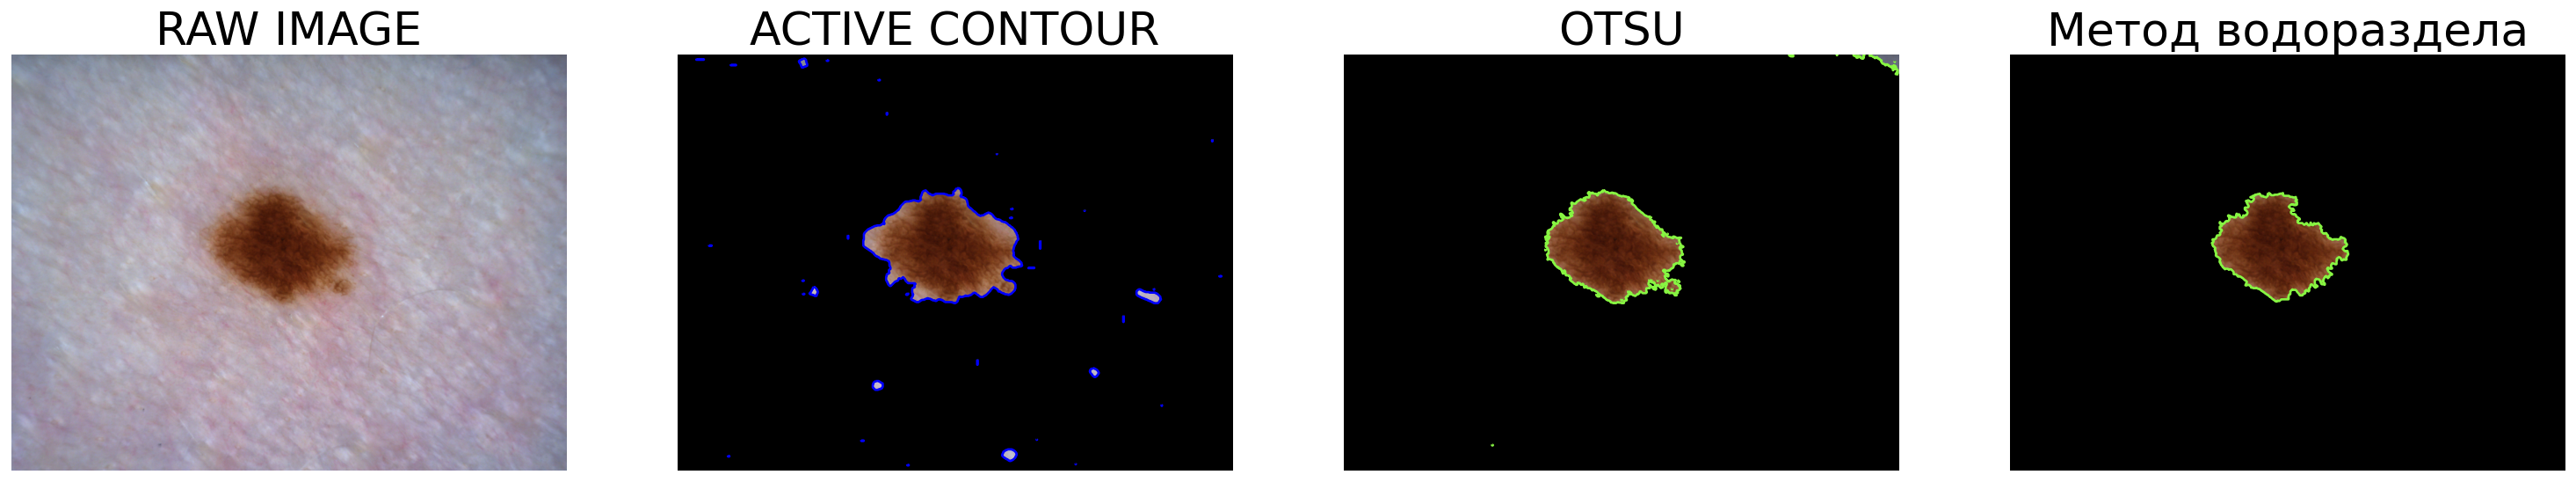

In [4]:
# для примера рассматривается один id картинки
image_numbers = [3155]


fig, axes = plt.subplots(1, 4, figsize=(30, 6), dpi=125)
ax = axes.flatten()

for number in tqdm(image_numbers):
    image_name = f'data/images/{number}.png'
    try:
        raw_image = io.imread(image_name)[:,:,:3]
        
        ax[0].imshow(raw_image)
        ax[0].set_axis_off()
        ax[0].set_title('RAW IMAGE', fontsize=30)

        AC_image, ls = AC(raw_image)
        ax[1].imshow(AC_image)
        ax[1].set_axis_off()
        ax[1].contour(ls, [0.5], colors='b')
        ax[1].set_title("ACTIVE CONTOUR", fontsize=30)

        OTSU_image, OTSU_mask = OTSU(raw_image)
        ax[2].imshow(OTSU_image)
        ax[2].set_axis_off()
        ax[2].contour(OTSU_mask, [0.5], colors='#87f542')
        ax[2].set_title("OTSU", fontsize=30)

        watershed_image, watershed_mask = my_watershed(raw_image)
        ax[3].imshow(watershed_image)
        ax[3].set_title("Метод водораздела", fontsize=30)
        ax[3].set_axis_off()
        ax[3].contour(watershed_mask, [0.5], colors='#87f542')

        fig.savefig('data/processed/{}'.format(image_name.split('/')[-1]), bbox_inches='tight')
#         ax[0].clear()
#         ax[1].clear()
#         ax[2].clear()
#         ax[3].clear()
    except Exception as ex:
        print(ex)